In [237]:
import gurobipy as gp
from gurobipy import GRB
import json
import pandas as pd
import numpy as np

In [238]:
"Loading the Solar Production Data";
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1a\DER_production.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Take the first row's hourly_profile_ratio list and make it a numpy array
Solar_CF = np.array(df["hourly_profile_ratio"][0])

In [239]:
Solar_CF

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.14, 0.21, 0.15, 0.12, 0.21,
       0.25, 0.85, 0.75, 0.55, 0.43, 0.23, 0.05, 0.25, 0.25, 0.  , 0.  ,
       0.  , 0.  ])

In [240]:
"Fullt Flexible Load (FFL) Data";
# Load JSON filen
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1a\usage_preference.json", "r") as f:
    data = json.load(f)

    data


In [241]:
min_FFL = data[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"]
min_FFL

8

In [242]:
"Electrcity Markert Data";
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1a\bus_params.json", "r") as f:
    data = json.load(f)

electricty_price = data[0]["energy_price_DKK_per_kWh"]

In [243]:
price_import = data[0]["import_tariff_DKK/kWh"]
price_export = data[0]["export_tariff_DKK/kWh"]
#------------------------------------------
penalty_excess_import = data[0]["penalty_excess_import_DKK/kWh"]
penalty_excess_export = data[0]["penalty_excess_export_DKK/kWh"]
#-----------------------------------------------------
max_import = data[0]["max_import_kW"]
max_export = data[0]["max_export_kW"]

In [244]:
max_export

500

In [245]:
"Ramping Up for Solar and FFL";
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1a\appliance_params.json", "r") as f:
    data = json.load(f)

max_power_solar = data["DER"][0]["max_power_kW"]
#min_power = data["DER"][0]["min_power_ratio"]
max_ramp_up_rate_solar = data["DER"][0]["max_ramp_rate_up_ratio"]
max_ramp_down_rate_solar = data["DER"][0]["max_ramp_rate_down_ratio"]

In [246]:
max_load_FFL = data["load"][0]["max_load_kWh_per_hour"]
min_load_FFL = data["load"][0]["min_load_ratio"]

max_ramp_up_rate_FFL= data["load"][0]["max_ramp_rate_up_ratio"]
max_ramp_down_rate_FFL= data["load"][0]["max_ramp_rate_down_ratio"]

In [247]:
max_load_FFL

3.0

- all units are in kW or KWh

In [248]:
t = range(len(Solar_CF))

In [249]:
max_load_FFL 

3.0

In [250]:
min_load_FFL

0.0

In [251]:
min_FFL

8

## Without Using Binary Variables (use this):

- according to chatgpt binary variables don´t allow for dual variables

In [252]:

# Create model
model = gp.Model("Prosumer_Continuous")

# Decision variables
x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=max_import)
x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=max_export)
x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)  # scaled 0-1
z_import_excess = model.addVars(t, name="excess_import_kW", lb=0)
z_export_excess = model.addVars(t, name="excess_export_kW", lb=0)

# Hourly constraints
for i in t:
    # FFL min/max
    model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL, name=f"FFL_min_{i}")
    model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL, name=f"FFL_max_{i}")

    # Energy balance
    model.addConstr(
        x_imports[i] - x_exports[i] + Solar_CF[i] * max_power_solar == x_FFL[i] * max_load_FFL,
        name=f"energy_balance_{i}"
    )

    # Excess import/export
    model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
    model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

    # Ramp constraints for FFL
    if i > 0:
        model.addConstr(
            (x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL,
            name=f"FFL_ramp_up_{i}"
        )
        model.addConstr(
            (x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL,
            name=f"FFL_ramp_down_{i}"
        )

# Minimum total daily FFL energy
model.addConstr(
    gp.quicksum(x_FFL[i] * max_load_FFL for i in t) >= min_FFL * max_load_FFL,
    name="FFL_min_total_energy"
)

# Objective: minimize cost + penalties
model.setObjective(
    gp.quicksum(
        price_import * x_imports[i] + penalty_excess_import * z_import_excess[i] +
        price_export * x_exports[i] + penalty_excess_export * z_export_excess[i]
        for i in t
    ),
    sense=GRB.MINIMIZE
)

# Solve
model.optimize()

# Print results and duals
print("Optimal objective value:", model.ObjVal)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 167 rows, 120 columns and 332 nonzeros
Model fingerprint: 0xd9178a5d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [1e+00, 1e+03]
  RHS range        [2e-01, 1e+03]
Presolve removed 151 rows and 74 columns
Presolve time: 0.01s
Presolved: 16 rows, 46 columns, 61 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.316250e+00   0.000000e+00      0s
       5    5.2650000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.03 seconds (0.00 work units)
Optimal objective  5.265000000e+00
Optimal objective value: 5.265000000000001


### New Updated Model.

- solar can be curtailed fully and is limited by it´s PV potential CF:

In [253]:
import gurobipy as gp
from gurobipy import GRB

# Create model
model = gp.Model("Prosumer_Continuous")

# Decision variables
x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)  # scaled 0-1
x_solar = model.addVars(t, name="solar_power_kW", lb=0)  # new solar variable

z_import_excess = model.addVars(t, name="excess_import_kW", lb=0)
z_export_excess = model.addVars(t, name="excess_export_kW", lb=0)

# Hourly constraints
for i in t:
    # FFL min/max
    model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL, name=f"FFL_min_{i}")
    model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL, name=f"FFL_max_{i}")

    # Solar production limit
    model.addConstr(x_solar[i] <= Solar_CF[i] * max_power_solar, name=f"solar_max_{i}")

    # Energy balance
    model.addConstr(
        x_imports[i] - x_exports[i] + x_solar[i] == x_FFL[i] * max_load_FFL,
        name=f"energy_balance_{i}"
    )

    # Excess import/export
    model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
    model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

    # Ramp constraints for FFL + Solar,  [t - 1] -> [t]
    if i > 0:
        model.addConstr(
            (x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL,
            name=f"FFL_ramp_up_{i}"
        )
        model.addConstr(
            (x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL,
            name=f"FFL_ramp_down_{i}"
        )

        # Ramp constraints for solar
        model.addConstr(
            x_solar[i] - x_solar[i-1] <= max_ramp_up_rate_solar * max_power_solar,
            name=f"solar_ramp_up_{i}"
        )
        model.addConstr(
            x_solar[i-1] - x_solar[i] <= max_ramp_down_rate_solar * max_power_solar,
            name=f"solar_ramp_down_{i}"
        )

# Minimum total daily FFL energy
model.addConstr(
    gp.quicksum(x_FFL[i] * max_load_FFL for i in t) >= min_FFL * max_load_FFL,
    name="FFL_min_total_energy"
)

# Objective: minimize cost + penalties
model.setObjective(
    gp.quicksum(
        +(price_import + electricty_price[i])*x_imports[i] + penalty_excess_import*z_import_excess[i] +
        -(-price_export + electricty_price[i])*x_exports[i] + penalty_excess_export*z_export_excess[i]
        for i in t
    ),
    sense=GRB.MINIMIZE
)

# Solve
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 237 rows, 144 columns and 472 nonzeros
Model fingerprint: 0x0053a203
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 191 rows and 45 columns
Presolve time: 0.01s
Presolved: 46 rows, 99 columns, 144 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4160000e+31   1.875000e+31   1.416000e+01      0s
      45    1.4377500e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.437750000e+01


In [254]:
# Ensure the model was solved to optimality
if model.Status == GRB.OPTIMAL:
    total_consumption = sum(x_FFL[i].X * max_load_FFL for i in t)
    print(f"Total energy consumed by the prosumer over 24 hours: {total_consumption:.2f} kWh")
else:
    print("Model not solved to optimality. Status:", model.Status)


Total energy consumed by the prosumer over 24 hours: 24.00 kWh


In [255]:
if model.status == GRB.OPTIMAL:
    for i in t:
        print(f"Hour {i}:")
        print(f"  Imported power = {x_imports[i].X:.2f} kW")
        print(f"  Exported power = {x_exports[i].X:.2f} kW")
        print(f"  FFL consumption = {x_FFL[i].X * max_load_FFL:.2f} kW")
        print(f"  Excess import = {z_import_excess[i].X:.2f} kW")
        print(f"  Excess export = {z_export_excess[i].X:.2f} kW")
        print(f"  Solar power used = {x_solar[i].X:.2f} kW")
else:
    print("Model not solved to optimality. Status:", model.status)


Hour 0:
  Imported power = 0.00 kW
  Exported power = 0.00 kW
  FFL consumption = 0.00 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Solar power used = 0.00 kW
Hour 1:
  Imported power = 0.00 kW
  Exported power = 0.00 kW
  FFL consumption = 0.00 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Solar power used = 0.00 kW
Hour 2:
  Imported power = 3.00 kW
  Exported power = 0.00 kW
  FFL consumption = 3.00 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Solar power used = 0.00 kW
Hour 3:
  Imported power = 3.00 kW
  Exported power = 0.00 kW
  FFL consumption = 3.00 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Solar power used = 0.00 kW
Hour 4:
  Imported power = 3.00 kW
  Exported power = 0.00 kW
  FFL consumption = 3.00 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  Solar power used = 0.00 kW
Hour 5:
  Imported power = 0.00 kW
  Exported power = 0.00 kW
  FFL consumption = 0.15 kW
  Excess import = 0.00 kW
  Excess export = 0.00 kW
  S

In [256]:
# Print dual variables (Pi) and slacks for all constraints
for constr in model.getConstrs():
    print(f"{constr.ConstrName}: dual = {constr.Pi:.4f}, slack = {constr.Slack:.4f}")

FFL_min_0: dual = 0.0000, slack = -0.0000
FFL_max_0: dual = 0.0000, slack = 3.0000
solar_max_0: dual = -1.6000, slack = 0.0000
energy_balance_0: dual = 1.6000, slack = 0.0000
excess_import_0: dual = 0.0000, slack = -1000.0000
excess_export_0: dual = 0.0000, slack = -500.0000
FFL_min_1: dual = 0.0000, slack = -0.0000
FFL_max_1: dual = 0.0000, slack = 3.0000
solar_max_1: dual = -1.5500, slack = 0.0000
energy_balance_1: dual = 1.5500, slack = 0.0000
excess_import_1: dual = 0.0000, slack = -1000.0000
excess_export_1: dual = 0.0000, slack = -500.0000
FFL_ramp_up_1: dual = 0.0000, slack = 3.0000
FFL_ramp_down_1: dual = 0.0000, slack = 3.0000
solar_ramp_up_1: dual = 0.0000, slack = 3.0000
solar_ramp_down_1: dual = 0.0000, slack = 3.0000
FFL_min_2: dual = 0.0000, slack = -3.0000
FFL_max_2: dual = 0.0000, slack = 0.0000
solar_max_2: dual = -1.5000, slack = 0.0000
energy_balance_2: dual = 1.5000, slack = 0.0000
excess_import_2: dual = 0.0000, slack = -997.0000
excess_export_2: dual = 0.0000, sla

### Adding Consumer Flexibility 1)a)v

In [319]:
import gurobipy as gp
from gurobipy import GRB

def prosumer_optimization(price_import, price_export, electricity_price,
                          penalty_excess_import, penalty_excess_export):
    """
    Prosumer optimization model to minimize procurement cost & penalties
    """

    # Create model
    model = gp.Model("Prosumer_Continuous")

    # Decision variables
    x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)  # scaled 0-1
    x_solar = model.addVars(t, name="solar_power_kW", lb=0)  
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0)
    delta_FFL = model.addVars(t, name="delta_FFL", lb=0, ub=GRB.INFINITY)

    # Hourly constraints
    for i in t:
        # FFL min/max
        model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL, name=f"FFL_min_{i}")
        model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL, name=f"FFL_max_{i}")

        # Solar production limit
        model.addConstr(x_solar[i] <= Solar_CF[i] * max_power_solar, name=f"solar_max_{i}")

        # Energy balance
        model.addConstr(
            x_imports[i] - x_exports[i] + x_solar[i] == x_FFL[i] * max_load_FFL,
            name=f"energy_balance_{i}"
        )

        # Excess import/export
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

        # Ramp constraints for FFL + Solar,  [t - 1] -> [t]
        if i > 0:
            model.addConstr(
                (x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_up_{i}"
            )
            model.addConstr(
                (x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_down_{i}"
            )

            # Ramp constraints for solar
            model.addConstr(
                x_solar[i] - x_solar[i-1] <= max_ramp_up_rate_solar * max_power_solar,
                name=f"solar_ramp_up_{i}"
            )
            model.addConstr(
                x_solar[i-1] - x_solar[i] <= max_ramp_down_rate_solar * max_power_solar,
                name=f"solar_ramp_down_{i}"
            )

            # Flexibility Constraint       
            model.addConstr(
                (x_FFL[i] - x_FFL[i-1]) * max_load_FFL <= delta_FFL[i],
                name=f"FFL_delta_up_{i}"
            )
            model.addConstr(
                (x_FFL[i-1] - x_FFL[i]) * max_load_FFL <= delta_FFL[i],
                name=f"FFL_delta_down_{i}"
            )

    # Minimum total daily FFL energy
    model.addConstr(
        gp.quicksum(x_FFL[i] * max_load_FFL for i in t) >= min_FFL * max_load_FFL,
        name="FFL_min_total_energy"
    )

    # Objective: minimize cost + penalties
    model.setObjective(
    gp.quicksum(
        -(price_import + electricity_price) * x_imports[i]
        -penalty_excess_import * z_import_excess[i]
        - (price_export - electricity_price) * x_exports[i]
        - penalty_excess_export * z_export_excess[i]
        for i in t
    ),
    sense=GRB.MAXIMIZE
)

    # Solve
    model.optimize()

    return model, x_imports, x_exports, x_FFL, x_solar, delta_FFL


In [329]:
# Ensure the model was solved to optimality
if model.Status == GRB.OPTIMAL:
    total_consumption = sum(x_FFL[i].X * max_load_FFL for i in t)
    print(f"Total energy consumed by the prosumer over 24 hours: {total_consumption:.2f} kWh")
else:
    print("Model not solved to optimality. Status:", model.Status)


Total energy consumed by the prosumer over 24 hours: 24.00 kWh


In [330]:
[model,x_imports, x_exports, x_FFL, x_solar, delta_FFL] = prosumer_optimization(price_import, price_export, electricity_price, penalty_excess_import, penalty_excess_export)

# Save results as arrays
imported_power = np.array([x_imports[i].X for i in t])
exported_power = np.array([x_exports[i].X for i in t])
FFL_consumption = np.array([x_FFL[i].X for i in t])
solar_power = np.array([x_solar[i].X for i in t])
delta_FFL_values = np.array([delta_FFL[i].X for i in t])

# Now you can print or use them as needed
print(imported_power)
print(exported_power)
print(FFL_consumption * max_load_FFL)
print(solar_power)   
print(delta_FFL_values)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 283 rows, 168 columns and 610 nonzeros
Model fingerprint: 0xee8674c8
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 237 rows and 77 columns
Presolve time: 0.02s
Presolved: 46 rows, 91 columns, 136 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4000000e+31   1.875000e+31   2.400000e+01      0s
      46   -2.6325000e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.04 seconds (0.00 work units)
Optimal objective -2.632500000e+01
[1.53 3.   3.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0. 

In [331]:
# Ensure the model was solved to optimality
if model.Status == GRB.OPTIMAL:
    total_consumption = sum(x_FFL[i].X * max_load_FFL for i in t)
    print(f"Total energy consumed by the prosumer over 24 hours: {total_consumption:.2f} kWh")
else:
    print("Model not solved to optimality. Status:", model.Status)

Total energy consumed by the prosumer over 24 hours: 24.00 kWh


In [356]:
np.sum(imported_power)

10.530000000000001

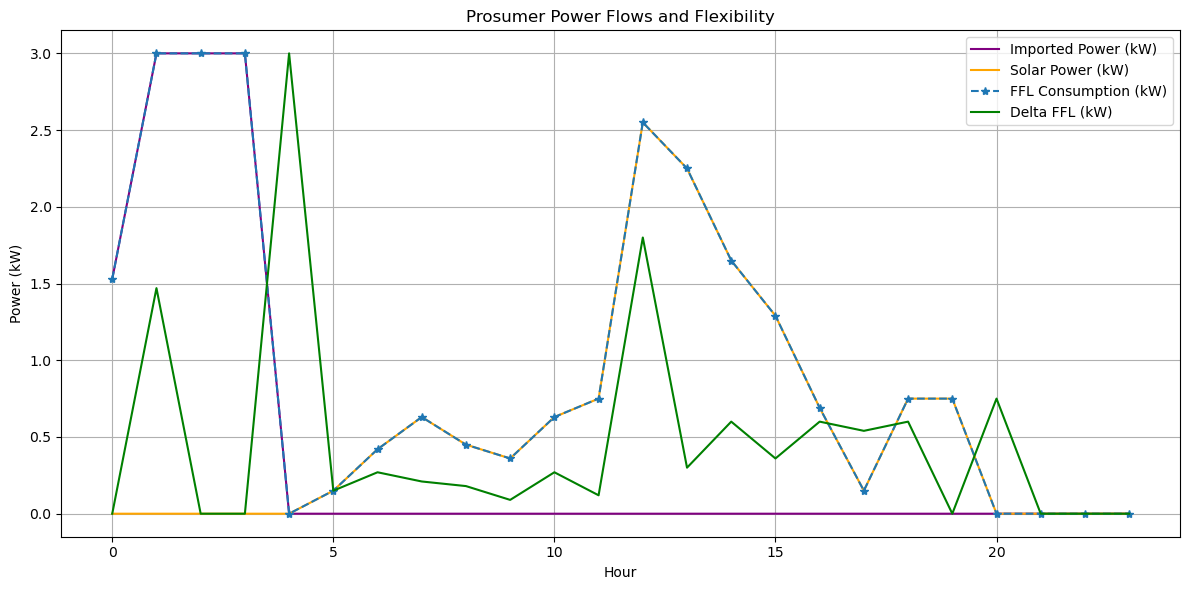

In [365]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(imported_power, label="Imported Power (kW)",color = "purple")
#plt.plot(exported_power, label="Exported Power (kW)")
plt.plot(solar_power ,label="Solar Power (kW)",color = "orange")
plt.plot(FFL_consumption * max_load_FFL,"*--" ,label="FFL Consumption (kW)")
plt.plot(delta_FFL_values, label="Delta FFL (kW)",color = "green")

plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Prosumer Power Flows and Flexibility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Sensitivty Analysis

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 283 rows, 168 columns and 610 nonzeros
Model fingerprint: 0x7631458a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 237 rows and 77 columns
Presolve time: 0.01s
Presolved: 46 rows, 91 columns, 136 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4000000e+31   1.875000e+31   2.400000e+01      0s
      46   -2.5798500e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds (0.00 work units)
Optimal objective -2.579850000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD 

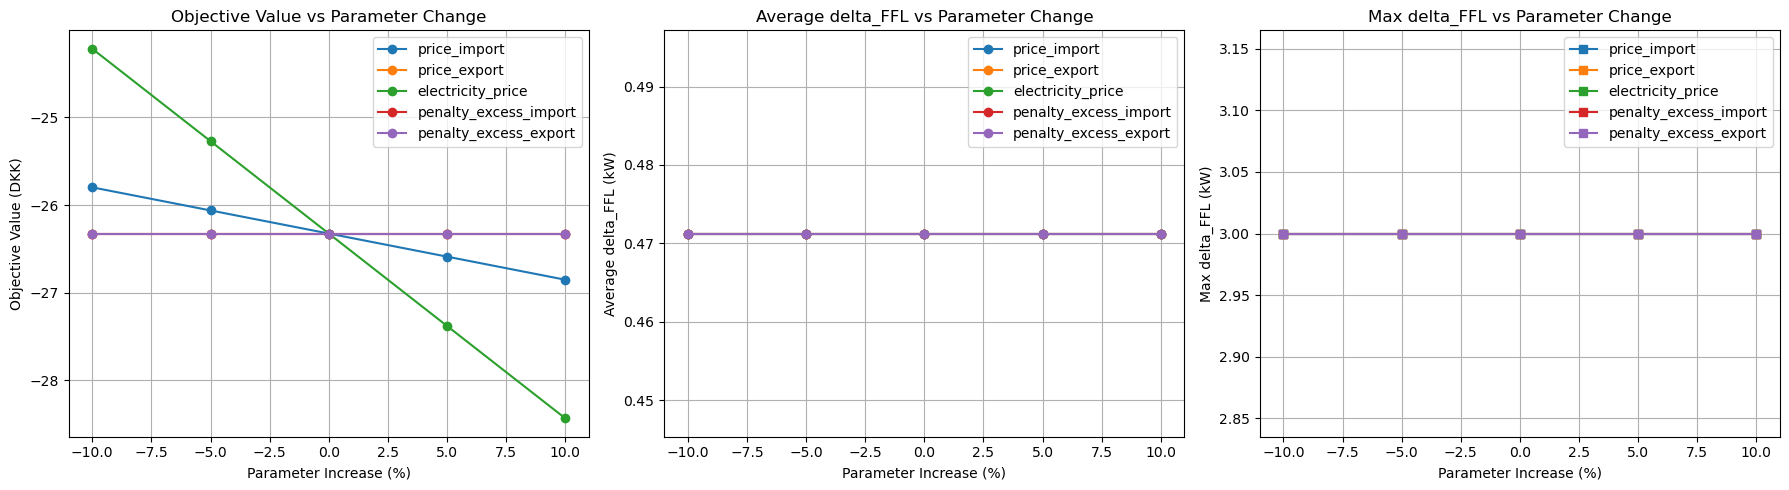

In [328]:
import matplotlib.pyplot as plt
import numpy as np

params = {
    "price_import": price_import,
    "price_export": price_export,
    "electricity_price": electricity_price,
    "penalty_excess_import": penalty_excess_import,
    "penalty_excess_export": penalty_excess_export
}

percent_changes = [-0.1,-0.05,0,0.05, 0.10]
results = {k: {"objective": [], "avg_delta": [], "max_delta": []} for k in params}

for param_name, base_value in params.items():
    for pct in percent_changes:
        new_params = params.copy()
        new_params[param_name] = base_value * (1 + pct)
        model, x_imports, x_exports, x_FFL, x_solar, delta_FFL = prosumer_optimization(
            new_params["price_import"],
            new_params["price_export"],
            new_params["electricity_price"],
            new_params["penalty_excess_import"],
            new_params["penalty_excess_export"]
        )
        delta_FFL_values = np.array([delta_FFL[i].X for i in t])
        results[param_name]["objective"].append(model.ObjVal)
        results[param_name]["avg_delta"].append(np.mean(delta_FFL_values))
        results[param_name]["max_delta"].append(np.max(delta_FFL_values))

# Plot all input changes in one figure for each metric
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for param_name in results:
    axs[0].plot([int(p*100) for p in percent_changes], results[param_name]["objective"], marker='o', label=param_name)
    axs[1].plot([int(p*100) for p in percent_changes], results[param_name]["avg_delta"], marker='o', label=param_name)
    axs[2].plot([int(p*100) for p in percent_changes], results[param_name]["max_delta"], marker='s', label=param_name)

axs[0].set_ylabel("Objective Value (DKK)")
axs[0].set_title("Objective Value vs Parameter Change")
axs[0].set_xlabel("Parameter Increase (%)")
axs[0].grid(True)
axs[0].legend()

axs[1].set_ylabel("Average delta_FFL (kW)")
axs[1].set_title("Average delta_FFL vs Parameter Change")
axs[1].set_xlabel("Parameter Increase (%)")
axs[1].grid(True)
axs[1].legend()

axs[2].set_ylabel("Max delta_FFL (kW)")
axs[2].set_title("Max delta_FFL vs Parameter Change")
axs[2].set_xlabel("Parameter Increase (%)")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 283 rows, 168 columns and 610 nonzeros
Model fingerprint: 0x7631458a
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 237 rows and 77 columns
Presolve time: 0.01s
Presolved: 46 rows, 91 columns, 136 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4000000e+31   1.875000e+31   2.400000e+01      0s
      46   -2.5798500e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.02 seconds (0.00 work units)
Optimal objective -2.579850000e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD 

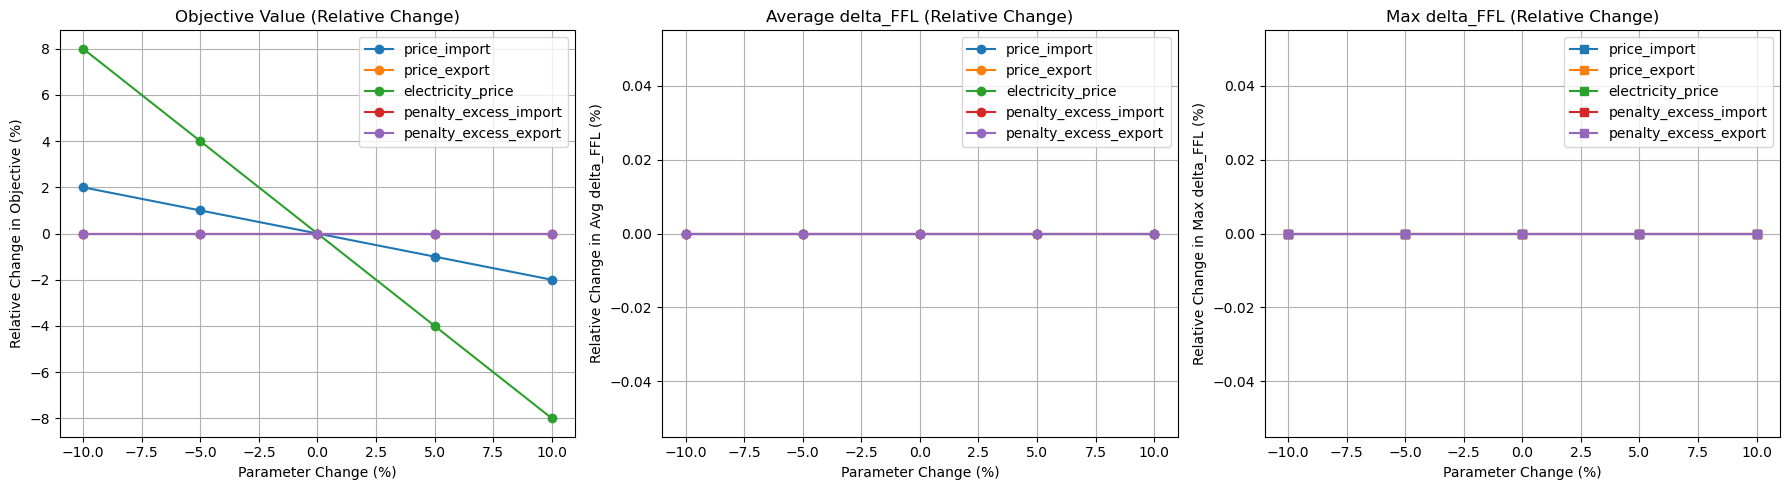

In [351]:
import matplotlib.pyplot as plt
import numpy as np

params = {
    "price_import": price_import,
    "price_export": price_export,
    "electricity_price": electricity_price,
    "penalty_excess_import": penalty_excess_import,
    "penalty_excess_export": penalty_excess_export
}

percent_changes = [-0.1, -0.05, 0, 0.05, 0.10]
results = {k: {"objective": [], "avg_delta": [], "max_delta": []} for k in params}

# Store base values for normalization
base_objective = {}
base_avg_delta = {}
base_max_delta = {}

for param_name, base_value in params.items():
    for idx, pct in enumerate(percent_changes):
        new_params = params.copy()
        new_params[param_name] = base_value * (1 + pct)
        model, x_imports, x_exports, x_FFL, x_solar, delta_FFL = prosumer_optimization(
            new_params["price_import"],
            new_params["price_export"],
            new_params["electricity_price"],
            new_params["penalty_excess_import"],
            new_params["penalty_excess_export"]
        )
        delta_FFL_values = np.array([delta_FFL[i].X for i in t])
        results[param_name]["objective"].append(model.ObjVal)
        results[param_name]["avg_delta"].append(np.mean(delta_FFL_values))
        results[param_name]["max_delta"].append(np.max(delta_FFL_values))
        # Save base values for normalization (pct==0)
        if pct == 0:
            base_objective[param_name] = model.ObjVal
            base_avg_delta[param_name] = np.mean(delta_FFL_values)
            base_max_delta[param_name] = np.max(delta_FFL_values)

# Plot relative change (0-100%) for all metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for param_name in results:
    rel_obj = 100 * (np.array(results[param_name]["objective"]) - base_objective[param_name]) / abs(base_objective[param_name])
    rel_avg = 100 * (np.array(results[param_name]["avg_delta"]) - base_avg_delta[param_name]) / abs(base_avg_delta[param_name])
    rel_max = 100 * (np.array(results[param_name]["max_delta"]) - base_max_delta[param_name]) / abs(base_max_delta[param_name])
    axs[0].plot([int(p*100) for p in percent_changes], rel_obj, marker='o', label=param_name)
    axs[1].plot([int(p*100) for p in percent_changes], rel_avg, marker='o', label=param_name)
    axs[2].plot([int(p*100) for p in percent_changes], rel_max, marker='s', label=param_name)

axs[0].set_ylabel("Relative Change in Objective (%)")
axs[0].set_title("Objective Value (Relative Change)")
axs[0].set_xlabel("Parameter Change (%)")
axs[0].grid(True)
axs[0].legend()

axs[1].set_ylabel("Relative Change in Avg delta_FFL (%)")
axs[1].set_title("Average delta_FFL (Relative Change)")
axs[1].set_xlabel("Parameter Change (%)")
axs[1].grid(True)
axs[1].legend()

axs[2].set_ylabel("Relative Change in Max delta_FFL (%)")
axs[2].set_title("Max delta_FFL (Relative Change)")
axs[2].set_xlabel("Parameter Change (%)")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()